In [17]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM  # perform F test

import selective_recruitment.globals as gl
# import Functional_Fusion.Functional_Fusion.dataset as ds 

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [18]:
# setting the directories
behav_dir = 'A:\\data\\Cerebellum\\CerebellumWorkingMemory\\data\\fmri'
wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'

# Analysis of Behvioral performance inside the scanner

## Working memory task

In [19]:
# get the behavioral dataframe
df = pd.read_csv(behav_dir + "/df_wm.tsv", sep = "\t")
D_wm = df[["isErrorM", "isError", "numErrors", "MnumErrors", "NMnumErrors"]]
D_wm["phase"] = df.exec
D_wm["load"] = df.load
D_wm["recall_dir"] = df.seqType
D_wm["sn"] = df.sn


d_phase = D_wm.phase.map({0:"encode", 1:"retriev"})
d_load = df.load.map({2: "L2", 4: "L4", 6: "L6"})
d_recall = df.seqType.map({1: "F", 0: "B"})

# L2B_encode	

D_wm["cond_name"] = d_load + d_recall + "_" + d_phase

# isCorrectM = 1 if all memory digits are correct
D_wm["isCorrectM"] = 1 - D_wm["isErrorM"] 

# isCorrectTot = 1 if the whole secuence is correct
D_wm["isCorrectTot"] = 1 - D_wm["isError"]

# get the number of errors in the non-memory digits
D_wm["nonmemError"] = D_wm["numErrors"] - D_wm["MnumErrors"]

# isErrorNM = 1 if there is at least one error in the non-memory digits
D_wm["isErrorNM"] = (D_wm["nonmemError"] > 0)*1

# isCorrectNM = 1 if all non-memory digits are correct
D_wm["isCorrectNM"] = 1 - D_wm["isErrorNM"]

### Behavioral performance 

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
load             9.4183 2.0000 30.0000 0.0007
recall_dir       8.8055 1.0000 15.0000 0.0096
load:recall_dir  0.0309 2.0000 30.0000 0.9696



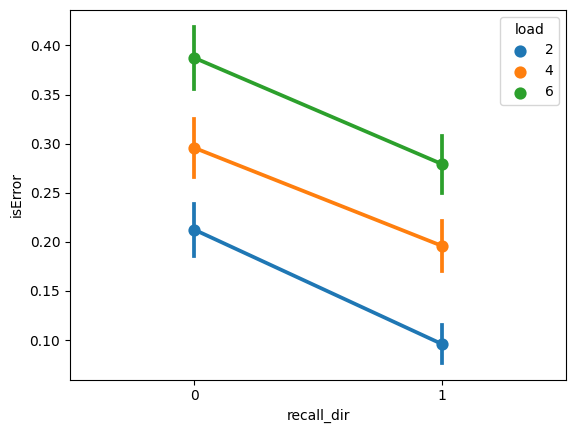

In [34]:
plotvar = "isError"
# ax = sns.barplot(data = D_wm.loc[D_wm.phase == 1], x = "load", y =  plotvar, 
#                  hue = "recall_dir", errorbar="se", palette=["r", "b"], 
#                  alpha = .8)

# ax = sns.barplot(data = D_wm.loc[D_wm.phase == 1], x = "recall_dir", y =  plotvar, 
#                  hue = "load", errorbar="se", 
#                  alpha = .8)

ax = sns.pointplot(data = D_wm.loc[D_wm.phase == 1], x = "recall_dir", y =  plotvar, 
                 hue = "load", errorbar="se")
# plt.setp(ax.collections, alpha=.8)
plt.savefig("wm_behaviour_percent_error_all.pdf")
print(AnovaRM(data=D_wm.loc[(D_wm.phase == 1)], depvar=plotvar,subject='sn', within=['load', 'recall_dir'], aggregate_func=np.mean).fit())


                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
load             0.0221 1.0000 15.0000 0.8838
recall_dir      16.6438 1.0000 15.0000 0.0010
load:recall_dir  0.1485 1.0000 15.0000 0.7054



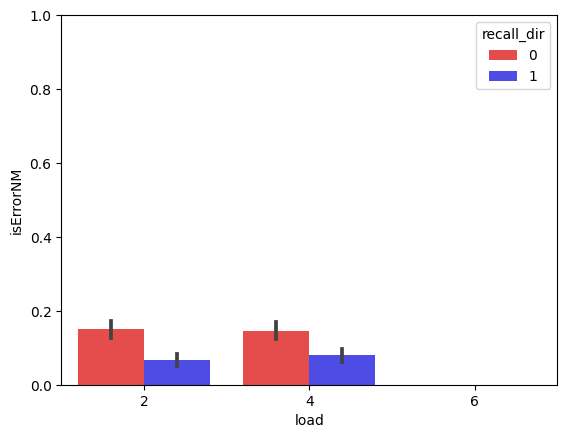

In [5]:
plotvar = "isErrorNM"
ax = sns.barplot(data = D_wm.loc[D_wm.phase == 1], x = "load", y =  plotvar, hue = "recall_dir", errorbar="se", palette=["r", "b"], alpha = 0.8)
# set the axis limits to 0-1
ax.set_ylim(0, 1)
# plt.setp(ax.collections, alpha=.8)
plt.savefig("wm_behaviour_percent_correct_nonMem.pdf")
print(AnovaRM(data=D_wm.loc[(D_wm.phase == 1) & (D_wm.load != 6)], depvar=plotvar,subject='sn', within=['load', 'recall_dir'], aggregate_func=np.mean).fit())
